# Deploy MongoDB Voyage AI model packages from AWS Marketplace

This notebook provides an example of how to deploy MongoDB Voyage AI model packages subscribed from the [AWS Marketplace](https://aws.amazon.com/marketplace/seller-profile?id=c9032c7b-70dd-459f-834f-c1e23cf3d092) as [real-time inferencing endpoints](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints.html) or [batch transform jobs](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html). A real-time inference API endpoint is a persistent, fully managed API endpoint designed for request-by-request inference. In contrast, a batch transform job is a finite execution designed for bulk inference of records in a dataset that writes predictions to a file. The following figure illustrates the workflow for deploying a model package for inference ([source](https://docs.aws.amazon.com/marketplace/latest/buyerguide/product-types-machine-learning-products.html#model-package-overview)).

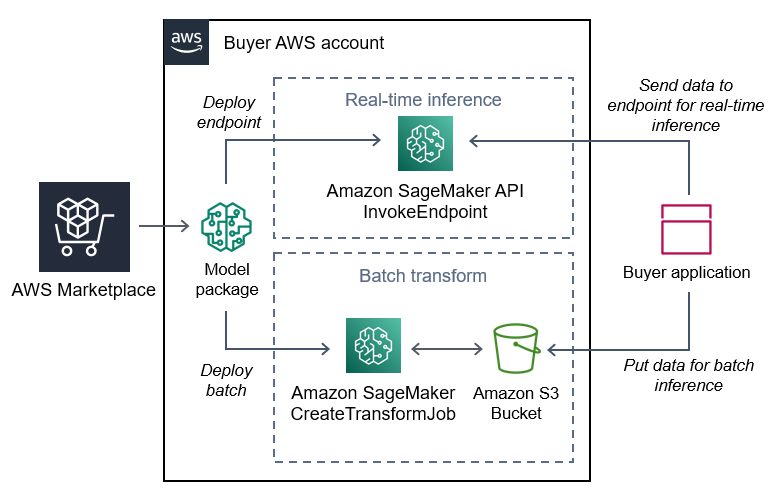

# 1 Prerequisites

In order to run this notebook, complete the following prerequisites. To learn more about how to complete these prerequisites, see the MongoDB Voyage AWS Marketplace model package [documentation](https://docs.voyageai.com/docs/deploy-mongodb-voyage-ai-models-using-aws-marketplace).

1. Subscribe to the [MongoDB Voyage AI model packages](hhttps://aws.amazon.com/marketplace/seller-profile?id=c9032c7b-70dd-459f-834f-c1e23cf3d092) you want to deploy.
2. Sufficient quota for the number and type of SageMaker instances you want to deploy your model packages on for your desired region and deployment type (real-time inferencing endpoint or batch job).

# 2 Configuration

## 2.1 Model Configuration

Set the ID of the model you want to deploy.

In [ ]:
# Set model ID to one of the following:
# "voyage-3.5", "voyage-3.5-lite", "voyage-3-large", "voyage-code-3"
MODEL_ID = "voyage-3.5"

Set the instance type you want to deploy on for the respective deployment type.  Be sure to check that the specified instance is supported for your model and deployment type.  You can do this by looking at the specific listing page for your model in the [AWS Marketplace](https://aws.amazon.com/marketplace/seller-profile?id=seller-snt4gb6fd7ljg).

In [ ]:
# G5 instances are Nvidia A10G GPUs.  G6 instances are Nvidia L4 GPUs. 
# "ml.g5.xlarge", "ml.g5.2xlarge", "ml.g5.4xlarge", "ml.g5.8xlarge",
# "ml.g5.16xlarge", "ml.g5.24xlarge", "ml.g5.48xlarge"
# "ml.g6.xlarge", "ml.g6.2xlarge", "ml.g6.4xlarge", "ml.g6.8xlarge",
# "ml.g6.16xlarge", "ml.g6.24xlarge", "ml.g6.48xlarge"
ENDPOINT_INSTANCE = "ml.g6.xlarge"
BATCH_INSTANCE = "ml.g5.2xlarge"

Like any AWS resource, model packages are uniquely identified by [Amazon Resource Names](https://docs.aws.amazon.com/IAM/latest/UserGuide/reference-arns.html) (ARN).  Specifically, we'll be identifying model packages with the following ARN format: `arn:partition:service:region:account-id:resource-type/resource-id`.

For example: `arn:aws:sagemaker:us-east-1:865070037744:model-package/voyage-3-5-v2-f1f46da5ecf736ee889516293c528987`

We separate the model package ARN into a prefix and its resource identifier (`resource-id`) and store them in the `arn_region_prefix` and `model_arn_resource_id` dictionaries, respectively. We provide a helper function to return the proper model package ARN given a model ID and region.

You can directly find the model package ARN for your subscribed model by looking at the model listing's configuration page in the [AWS Marketplace](https://aws.amazon.com/marketplace/seller-profile?id=c9032c7b-70dd-459f-834f-c1e23cf3d092).

In [ ]:
model_arn_resource_id = {
    "voyage-3.5-lite": "voyage-3-5-lite-9e7d9de900bb387d94a5b909206fcf40",
    "voyage-3.5": "voyage-3-5-v2-f1f46da5ecf736ee889516293c528987",
    "voyage-3-large": "voyage-3-large-updated-4cefad4269b037efa49eb078a2db522e",
    "voyage-code-3": "voyage-code-3-22d7879593f334709185560a458771a5",
}

In [ ]:
arn_region_prefix = {
    "us-east-1": "arn:aws:sagemaker:us-east-1:865070037744:model-package/",
    "us-east-2": "arn:aws:sagemaker:us-east-2:057799348421:model-package/",
    "us-west-1": "arn:aws:sagemaker:us-west-1:382657785993:model-package/",
    "us-west-2": "arn:aws:sagemaker:us-west-2:594846645681:model-package/",
    "ca-central-1": "arn:aws:sagemaker:ca-central-1:470592106596:model-package/",
    "eu-central-1": "arn:aws:sagemaker:eu-central-1:446921602837:model-package/",
    "eu-west-1": "arn:aws:sagemaker:eu-west-1:985815980388:model-package/",
    "eu-west-2": "arn:aws:sagemaker:eu-west-2:856760150666:model-package/",
    "eu-west-3": "arn:aws:sagemaker:eu-west-3:843114510376:model-package/",
    "eu-north-1": "arn:aws:sagemaker:eu-north-1:136758871317:model-package/",
    "ap-southeast-1": "arn:aws:sagemaker:ap-southeast-1:192199979996:model-package/",
    "ap-southeast-2": "arn:aws:sagemaker:ap-southeast-2:666831318237:model-package/",
    "ap-northeast-2": "arn:aws:sagemaker:ap-northeast-2:745090734665:model-package/",
    "ap-northeast-1": "arn:aws:sagemaker:ap-northeast-1:977537786026:model-package/",
    "ap-south-1": "arn:aws:sagemaker:ap-south-1:077584701553:model-package/",
    "sa-east-1": "arn:aws:sagemaker:sa-east-1:270155090741:model-package/"
}

In [ ]:
# Returns the model package ARN given a model ID and region
def get_model_package_arn(model_id, region):
    return arn_region_prefix[region] + model_arn_resource_id[model_id]

## 2.2 Initialize SageMaker runtime client

Install, upgrade, and import the AWS SDK for Python ([Boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html)).

In [ ]:
!pip install boto3 --upgrade

In [ ]:
pip install sagemaker

In [ ]:
import boto3

Import required packages.

In [ ]:
import json
import sagemaker as sage
from sagemaker import get_execution_role, ModelPackage
import time
import pprint
pp2 = pprint.PrettyPrinter(indent=2, width=80, compact=True, depth=2)
pp3 = pprint.PrettyPrinter(indent=2, width=80, compact=True, depth=3)

Determine the current AWS region of the boto3 session.

In [ ]:
current_region = boto3.Session().region_name
print("Current AWS Region: " + current_region)

# Validate if the current region is supported
if current_region not in arn_region_prefix:
    raise Exception(f"The region {current_region} of the current boto3 session is not supported.")

Initialize the SageMaker runtime.

In [ ]:
session = sage.Session()
role = get_execution_role()
sm_runtime = boto3.client("sagemaker-runtime")

## 2.3 Initialize the model

Retrieve the model package [Amazon Resource Name](https://docs.aws.amazon.com/IAM/latest/UserGuide/reference-arns.html) (ARN) for your model in the current region.

In [ ]:
model_package_arn = get_model_package_arn(MODEL_ID, current_region)
print(f"Model package ARN: {model_package_arn}")

Create a model instance.

In [ ]:
model = ModelPackage(
    role=role,
    model_package_arn=model_package_arn,
    sagemaker_session=session,
)

# 3 Real-time inference endpoint

## 3.1 Deploy real-time inference endpoint

The following step deploys the model endpoint to Sagemaker and may take up to 10 minutes.


In [ ]:
print("Deploying " + MODEL_ID + " as real-time inference endpoint on " + ENDPOINT_INSTANCE + ".")
start_time_endpoint = time.time()
model.deploy(
    initial_instance_count=1,
    instance_type=ENDPOINT_INSTANCE,
    endpoint_name=MODEL_ID,
)
end_time_endpoint = time.time()
elapsed_time_endpoint = end_time_endpoint - start_time_endpoint
print(f"\nSuccessfully deployed {MODEL_ID} as real-time inference endpoint on {ENDPOINT_INSTANCE} in {str(elapsed_time_endpoint)} seconds.")

## 3.2 Invoke text embedding endpoint

If you deployed a text embedding model endpoint, the following code invokes the endpoint on a sample input texts, which is a batch of two queries.  For an explanation of possible parameters, see the "Usage Information" section of the specific listing page for your model the [AWS Marketplace](https://aws.amazon.com/marketplace/seller-profile?id=c9032c7b-70dd-459f-834f-c1e23cf3d092).  Of particular interest is the `input_type` parameter.  For retrieval tasks, `input_type` should be set to "query" if the input text are queries and set to "document" if the input text are documents.  You can read more about the `input_type` parameter [here](https://docs.voyageai.com/docs/faq#when-and-how-should-i-use-the-input_type-parameter).

In [ ]:
# Example embedding input data
input_embedding = '''{
    "input": ["Sample text 1", "Sample text 2"],
    "input_type": "query",
    "truncation": "true"
  }'''

print("Example input data for embedding model endpoint:")
print(input_embedding)

response = sm_runtime.invoke_endpoint(
    EndpointName=model.endpoint_name,
    ContentType="application/json",
    Accept="application/json",
    Body=input_embedding
)

print("\nEmbedding endpoint response:")
response = json.load(response["Body"])
pp3.pprint(response)

## 3.3 Invoke text embedding endpoint in batches

When you have many, say, *n* documents, you can vectorize each of them with a `for` loop. This will often result in many requests. Alternatively, you can send requests consisting of batches of documents to reduce the number of requests to the API endpoint. We give an example below with a dataset of *n*=10 documents. 

In [ ]:
documents = [
    "The future of quantum computing in cryptographic applications.",
    "The application of neural networks in autonomous vehicle systems.",
    "Analyzing the role of big data in personalized healthcare solutions.",
    "The evolution of cloud computing in enterprise software development.",
    "Assessing the impact of IoT on smart city infrastructure.",
    "The potential of edge computing for real-time data processing.",
    "Evaluating the effectiveness of AI in fraud detection systems.",
    "Challenges and opportunities in developing ethical AI algorithms.",
    "The integration of 5G technology in enhancing IoT connectivity.",
    "Advancements in biometric authentication methods for secure transactions."
]

The following code demonstrates how to group the documents into batches and invoke the endpoint repeatedly to vectorize the whole dataset.  Specifically, the example code loops over the 10 documents in batches of size 5 (i.e., `batch_size`=5).

In [ ]:
if model_is_text_embedding(MODEL_ID):
	encoded_data = []
	batch_size = 5
	
	# Loop over the documents in increments of the batch size
	for i in range(0, len(documents), batch_size):
	    input = json.dumps({
	        "input": documents[i:i+batch_size],
	        "input_type": "document",
	        "truncation": "true"
	    })
	    
	    response = sm_runtime.invoke_endpoint(
	        EndpointName=model.endpoint_name,
	        ContentType="application/json",
	        Accept="application/json",
	        Body=input,
	    )
	
	    response = json.load(response["Body"])
        
        # Concatenating vectors into a single list; preserve original index
	    encoded_data.extend({"embedding": data[1]["embedding"], "index": data[0] } for 
                            data in zip(range(i,i+batch_size), response["data"]))
	
	# Print the response data
	pp2.pprint(encoded_data)

## 3.4 Terminate endpoint (to avoid unnecessary charges)

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. You can terminate the endpoint to avoid being charged.

In [ ]:
print("Deleting " + model.endpoint_name + " real-time inference endpoint.")
model.sagemaker_session.delete_endpoint(model.endpoint_name)
model.sagemaker_session.delete_endpoint_config(model.endpoint_name)
model.delete_model()

# 4 Batch transform job

The batch transform job example is only for text embedding models.  So, you can skip this section if you are using a reranker.

## 4.1 Set up a batch transform job

Use default S3 bucket for input and output data.

In [ ]:
s3_bucket = session.default_bucket()
print(f"Default SageMaker Session Bucket: {s3_bucket}")

Initialize S3 client.

In [ ]:
s3_client = session.boto_session.client("s3")

## 4.2 Create and store example data

Define batch transform job input file name.

In [ ]:
INPUT_FILE_NAME_EMBEDDING = "batch-input-embedding.jsonl"

Create an example input file using our example documents dataset above.  Each line in the example input file contains a single document from our dataset and a batch transform request ID (`id`).  If specified, the batch transform request ID (`id`) value will be part of the output prediction record, matching it with the corresponding input data record.  

Example input record:
`{"id": "0", "input": "The future of quantum computing in cryptographic applications."}`

Example output prediction record:
`{"data": [ {"embedding": [...], "index": 0, "object": "embedding"}],
"model": 'voyage-multilingual-2',
"object": "list",
"usage": {"total_tokens": 11},
"id": "0"}`

In [ ]:
with open(INPUT_FILE_NAME_EMBEDDING, "w") as f:
    for index, doc in enumerate(documents):
        json_line = json.dumps({"id": str(index), "input": doc})
        f.write(json_line + "\n")
print(f"Created example data in {INPUT_FILE_NAME_EMBEDDING}")

Define input and output S3 paths.

In [ ]:
batch_input_path_embedding = f"s3://{s3_bucket}/batch_transform_embedding/input/"
batch_output_path_embedding = f"s3://{s3_bucket}/batch_transform_embedding/output/"

Put example input file to S3.

In [ ]:
with open(INPUT_FILE_NAME_EMBEDDING, "r") as f:
    file_content = f.read()
    s3_client.put_object(Bucket=s3_bucket, Key="batch_transform_embedding/input/"+INPUT_FILE_NAME_EMBEDDING, Body=file_content)

## 4.3 Initialize batch transformer

In [ ]:
transformer = model.transformer(
            instance_count=1,
            instance_type=BATCH_INSTANCE,
            output_path=batch_output_path_embedding,
            strategy="SingleRecord"
        )

## 4.4 Run job (which can take up to 10 minutes)

Note, that this example batch transform job is known to take up to 10 minutes because it is using the provided example generated data.  More generally, the duration of the batch transform job will depend on the size of the input dataset to inference.

In [ ]:
print("Deploying a " + MODEL_ID + " batch transform job on " + BATCH_INSTANCE + ".  Output will be at " + batch_output_path_embedding + ".")
start_time_batch = time.time()
transformer.transform(
    data=batch_input_path_embedding,
    content_type="application/jsonlines",
    split_type="Line",
    wait=True,
    logs=False, # Whether to show the logs produced by the job. Setting to False.
)
end_time_batch = time.time()
elapsed_time_batch = end_time_batch - start_time_batch
print(f"\nSuccessfully completed {MODEL_ID} batch transform job on {BATCH_INSTANCE} in {str(elapsed_time_batch)} seconds.")